In [1]:
# Import dependencies
import torch
import torch.nn.functional as F

import phog.pcfg_models as pcfg_models
import phog.pcfg_loader as loader
import source as source


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [2]:
loader_params = {
    'datafolder': 'training',
    'batch_size': 1,
    'shuffle': True,
    'only_inputs': True,
    'print_steps': True,
    'moves_per_step': 1,
    'max_steps': 1,
    'p_use_base': 0.25,
}
data_yielder = loader.get_pcfg_datayielder(**loader_params)

pcfg_filename = 'pcfg_encoder_20241204_091144.pth'
pcfg_encoder = pcfg_models.PCFG_Encoder.load_model(f"phog/trained_pcfg_models/{pcfg_filename}", print_statements=True, device=device)

C:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\phog\pcfg_models\pcfg_encoder.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Vision Transformer instantiated with 117,472 parameters using Sinusoidal encodings.
PCFG encoder instantiated with 52,288 parameters.


In [3]:
def embed_input(input, pcfg_encoder, use_grads, device):
    x = torch.zeros((len(input), pcfg_encoder.model_params['n_embd']), device=device)
    special_tokens = pcfg_encoder.get_special_tokens(device)   # cls_dsl, cls_obj, pad, sep
    
    try:
        first_pad = input[:16].index('<PAD>')
    except ValueError:
        first_pad = 16
    
    for i, obj in enumerate(input):
        if obj == "<PAD>":
            x[i, :] = special_tokens[2, :]
        elif obj == "<SEP>":
            x[i, :] = special_tokens[3, :]
        elif isinstance(obj, source.ARC_Object):
            obj.set_embedding(pcfg_encoder.embedding_model, use_grads=use_grads)
            x[i, :] = obj.embedding.to(device)
        else:
            raise NameError("Input contains object that is not '<PAD>', '<SEP>', or an ARC_Object.")
    x = torch.cat((special_tokens[:2, :], x), dim=0)
    return x, first_pad

Problem ID: 42a50994-input-0, [1/1]
Transformation applied: recolor on base.
Input:


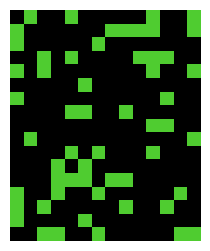

Output:


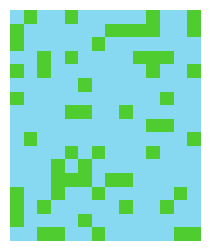

 copy_translate: 0.199
      draw_line: 0.197
        recolor: 0.161
    single_copy: 0.134
          color: 0.127
         rotate: 0.102
      translate: 0.047
           flip: 0.025
         delete: 0.008

Problem ID: 6455b5f5-input-0, [1/1]
Transformation applied: copy_translate on objects.
Input:


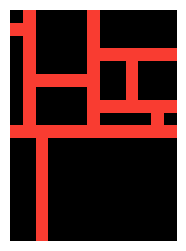

Output:


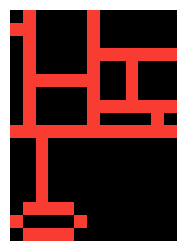

 copy_translate: 0.200
      draw_line: 0.197
        recolor: 0.161
    single_copy: 0.135
          color: 0.126
         rotate: 0.102
      translate: 0.047
           flip: 0.025
         delete: 0.008

Problem ID: 9d9215db-input-0, [1/1]
Transformation applied: draw_line on objects.
Input:


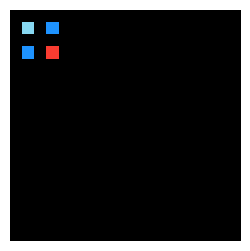

Output:


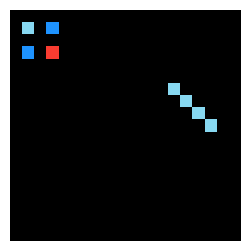

 copy_translate: 0.199
      draw_line: 0.196
        recolor: 0.161
    single_copy: 0.135
          color: 0.127
         rotate: 0.102
      translate: 0.047
           flip: 0.025
         delete: 0.008

Problem ID: bc1d5164-input-2, [1/1]
Transformation applied: translate on objects.
Input:


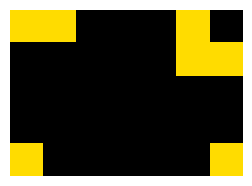

Output:


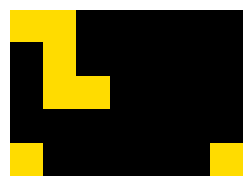

 copy_translate: 0.200
      draw_line: 0.196
        recolor: 0.160
    single_copy: 0.135
          color: 0.127
         rotate: 0.102
      translate: 0.047
           flip: 0.025
         delete: 0.008

Problem ID: 08ed6ac7-input-0, [1/1]
Transformation applied: delete on objects.
Input:


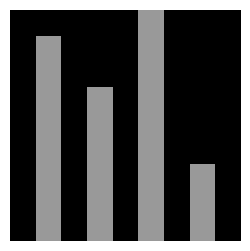

Output:


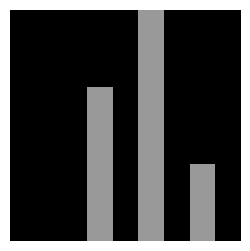

 copy_translate: 0.199
      draw_line: 0.196
        recolor: 0.161
    single_copy: 0.135
          color: 0.127
         rotate: 0.102
      translate: 0.047
           flip: 0.025
         delete: 0.008



In [4]:
print_samples = loader_params['print_steps']
ftoi = pcfg_encoder.dsl_mapping
itof = {value: key.__name__ for key, value in ftoi.items()}

for i in range(5):
    try:
        key, input, label, obj_indices = next(data_yielder)
    except Exception as e:
        print(f"Exception raised: {e}")
        continue
    
    x, first_pad = embed_input(input, pcfg_encoder, use_grads=not pcfg_encoder.freeze_emb_model, device=device)
    dsl_cls, obj_att = pcfg_encoder(x)
    obj_att = obj_att[2:first_pad + 2]

    dsl_cls = F.softmax(dsl_cls, dim=-1).to('cpu').tolist()
    obj_att = F.softmax(obj_att, dim=-1).to('cpu')

    dsl_labels = [(val, itof[i]) for i, val in enumerate(dsl_cls)]
    dsl_labels.sort(reverse=True)
    for v, f in dsl_labels:
        print(f"{f:>15}: {v:.3f}")
    

    print(f"")